In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [49]:
import nengo_bio as bio
import nengo as nengo
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import matplotlib.patches
import numpy as np
import json
import os
import multiprocessing
from tqdm import tqdm
import scipy.stats
import scipy.optimize

In [25]:
def compute_response_curve(constructor, J_min=-20e-12, J_max=100e-12, max_rate=100, dJ=20.0e-12, dt=1e-3, T=10.0):
    Js, Gs = [], []
    J, rate = J_min, 0

    # Repeat until either the maximum current or the maximum rate is reached
    while (J < J_max) and (rate < max_rate):
        # Compile the neuron simulator
        sim = constructor().compile(dt, 1)
        spike_out = np.zeros(1)
        n_spikes = 0
        for t in np.arange(0, T, dt):
            J_cur = J + np.random.normal(0, 1e-11)
            J_in_exc = np.ones(1) * np.clip(J_cur, 0, None)
            J_in_inh = np.ones(1) * np.clip(-J_cur, 0, None)
            sim(spike_out, J_in_exc, J_in_inh)
            if spike_out > 0:
                n_spikes = n_spikes + 1

        # Record the J, G[J] tuple
        rate = n_spikes / T
        Js.append(J)
        Gs.append(rate)

        # Increase the current
        J += dJ

    return np.array(Js), np.array(Gs)

In [26]:
def _compute_response_curve_single(p):
    i, E_rev_leak = p
    return i, compute_response_curve(lambda: bio.neurons.LIF(
        C_som=5e-12,
        g_leak_som=3.5e-10,
        v_th=-35e-3,
        tau_ref=1e-3,
        tau_spike=0e-3,
        E_rev_leak=E_rev_leak,
        v_reset=E_rev_leak,
    ))

In [27]:
# Original data
orig_bins = np.linspace(-90,-30, 16)
orig_qty = np.array([0, 2, 4, 4, 6, 15, 12, 12, 8, 3, 5, 1, 3, 0, 0])
orig_qty_density = orig_qty / (np.sum(orig_qty) * 4)

orig_Js, orig_Gs = np.array([5.7789,-0.0357,
8.392,1.6794,
10.9045,5.0251,
13.4171,9.3899,
15.8543,13.302,
18.392,16.9873,
20.9799,19.4045,]).reshape(-1, 2).T
orig_Gs /= 0.2 # spike count measured over a 250ms interval


p_mu, p_sigma = scipy.optimize.curve_fit(scipy.stats.norm.pdf, orig_bins[:-1] + 2, orig_qty_density, p0=(-64, 10))[0]
ps = np.linspace(-90, -30, 100)
ps_density = scipy.stats.norm.pdf(ps, p_mu, p_sigma)

In [28]:
n_E_rev_leak = 16

Js_lst = [None] * n_E_rev_leak
Gs_lst = [None] * n_E_rev_leak
E_rev_leaks = np.concatenate(([-64e-3], np.random.normal(p_mu * 1e-3, p_sigma * 1e-3, n_E_rev_leak - 1)))
with multiprocessing.Pool(16) as pool:
    for i, (Js, Gs) in tqdm(pool.imap_unordered(
            _compute_response_curve_single,
            enumerate(E_rev_leaks))):
        Js_lst[i] = Js
        Gs_lst[i] = Gs

16it [00:05,  3.18it/s]


In [29]:
#from datetime import datetime
#fn = "tuning_curves_" + datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
#np.save(fn, {
#    "Js_lst": Js_lst,
#    "Gs_lst": Gs_lst,
#     "E_rev_leaks": E_rev_leaks,
#})

In [30]:
# Load the tuning curves
#data = np.load("tuning_curves_2020-04-23_22_19_08.npy", allow_pickle=True).item()
#Js_lst = data["Js_lst"]
#Gs_lst = data["Gs_lst"]

In [31]:
# Fit ReLUs to the measured data
gains, biases = np.zeros((2, n_E_rev_leak))
valid = [False] * n_E_rev_leak
for i in range(n_E_rev_leak):
    Js, Gs = Js_lst[i], Gs_lst[i]
    Gs_valid = Gs > 5
    if np.sum(Gs_valid) >= 2:
        gains[i], biases[i] = np.polyfit(Js[Gs_valid], Gs[Gs_valid], 1)
        if biases[i] < 150:
            valid[i] = True

<ipython-input-48-12d5b9382115>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_xticklabels(['$-75\\mathrm{mV}$', '$-50\\mathrm{mV}$'])
<ipython-input-48-12d5b9382115>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=-0.25)


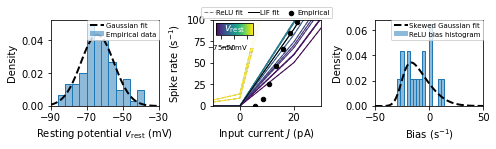

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(7, 2.25))

Blue = cm.get_cmap('tab10')(0)

axs[0].bar(orig_bins[:-1] + 2, orig_qty_density, width=4, fill=True, color=Blue, alpha=0.5, label='Empirical data')
axs[0].bar(orig_bins[:-1] + 2, orig_qty_density, width=4, fill=False, edgecolor=Blue)
axs[0].plot(ps, ps_density, color='k', linestyle='--', linewidth=2, label='Gaussian fit')
axs[0].set_xlim(-90, -30)
axs[0].set_xticks([-90, -70, -50, -30])
axs[0].set_ylabel("Density")
axs[0].set_xlabel("Resting potential $v_\\mathrm{rest}$ (mV)")
axs[0].legend(
    loc='upper right',
    fontsize=7,
    borderaxespad=0,
    handlelength=2,
    handletextpad=0.2,
    labelspacing=0.4)

cmap = cm.ScalarMappable(
    matplotlib.colors.Normalize(
        vmin=np.percentile(E_rev_leaks, 5) * 1e3,
        vmax=np.percentile(E_rev_leaks, 95) * 1e3),
    'viridis')

for i in range(0, n_E_rev_leak, 1):
    if not valid[i]:
        continue
    color = cmap.to_rgba(E_rev_leaks[i] * 1e3) #* np.array((0.9, 0.9, 0.9, 1.0))
    Js, Gs = Js_lst[i], Gs_lst[i]
    axs[1].plot(Js * 1e12, Gs, color=color, zorder=1, linewidth=1)
    label = 'ReLU fit' if i == 0 else None
    axs[1].plot(Js * 1e12, np.maximum(0, gains[i] * Js + biases[i]),
               color='gray', linestyle='--', linewidth=1, zorder=0, label=label)
axs[1].plot(Js_lst[0] * 1e12, Gs_lst[0], linestyle='-', color='k', linewidth=1, label='LIF fit')
axs[1].scatter(orig_Js, orig_Gs, color='k', marker='o', zorder=3, s=20, label='Empirical')
axs[1].set_xlim(-10, 30)
axs[1].set_ylim(0, 100)
axs[1].set_ylabel('Spike rate ($\\mathrm{s}^{-1}$)')
axs[1].set_xlabel('Input current $J$ (pA)')
axs[1].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=7,
    borderaxespad=0,
    handlelength=1.5,
    handletextpad=0.2,
    columnspacing=0.8,
    labelspacing=0.4)

cax = fig.add_axes([0.435, 0.725, 0.075, 0.075])
plt.colorbar(cmap, cax=cax, orientation='horizontal')
#cax.set_xlabel('$v_\\mathrm{rest}$', labelpad=-14)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(7) 
cax.set_xticklabels(['$-75\\mathrm{mV}$', '$-50\\mathrm{mV}$'])
cax.text(0.5, 0.5, '$v_\\mathrm{rest}$', va='center', ha='center', color='white', transform=cax.transAxes)

rect = matplotlib.patches.Rectangle((0.1, 0.675), 0.4, 0.325, facecolor='white', transform=axs[1].transAxes, zorder=2, alpha=0.9)
axs[1].add_patch(rect)

α, β = np.polyfit(biases[biases < 50], gains[biases < 50] * 1e-12, 1)
xs = np.linspace(-50, 50, 100)

#axs[2].plot(biases, gains * 1e-12, '+', color=Blue, alpha=0.5, markersize=5, markeredgecolor=None)
#axs[2].plot(xs, α * xs + β, 'k--', linewidth=2)
#axs[2].set_xlim(-50, 50)
#axs[2].set_xlabel('Bias ($\\mathrm{s}^{-1}$)')
#axs[2].set_ylabel('Gain ($\\mathrm{s}^{-1}/pA$)')

p = scipy.stats.skewnorm.fit(biases[biases < 50], 0.1, loc=0, scale=1)

axs[2].hist(biases[biases < 50], bins=15, fill=False, edgecolor=Blue, density=True)
axs[2].hist(biases[biases < 50], bins=15, fill=True, color=Blue, alpha=0.5, density=True, label='ReLU bias histogram')
axs[2].plot(xs, scipy.stats.skewnorm.pdf(xs, *p), 'k--', linewidth=2, label='Skewed Gaussian fit')
axs[2].set_xlabel('Bias ($\\mathrm{s}^{-1}$)')
axs[2].set_ylabel('Density')
axs[2].set_xlim(-50, 50)
axs[2].legend(
    loc='upper right',
    fontsize=7,
    borderaxespad=0,
    handlelength=2,
    handletextpad=0.2,
    labelspacing=0.4)

fig.tight_layout(w_pad=-0.25)
fig.savefig('granule_response_curve_exploration.pdf', bbox_inches='tight', transparent=True)

Text(0, 0.5, 'Firing rate')

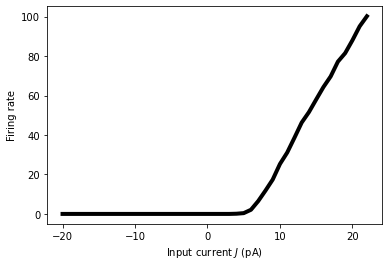

In [9]:
fig, ax = plt.subplots()
for i in range(0, n_E_rev_leak, 16):
    if not valid[i]:
        continue

    Js, Gs = Js_lst[i], Gs_lst[i]

    v = (E_rev_leaks[i] - np.min(E_rev_leaks)) / (np.max(E_rev_leaks) - np.min(E_rev_leaks))

    if i == 0:
        color1 = 'k'
    else:
        color1 = cm.get_cmap('viridis')(v) * np.array((0.9, 0.9, 0.9, 1.0))
    color2 = (0.25, 0.25, 0.25, 1.0)

    linewidth = 1 if i > 0 else 4

#    ax.plot(Js * 1e12, np.maximum(0, gains[i] * Js + biases[i]),
#            color=color2, linestyle='--', linewidth=1, zorder=1)
    ax.plot(Js * 1e12, Gs, color=color1, linewidth=linewidth, zorder=0 if i > 0 else 2)

ax.set_xlabel('Input current $J$ (pA)')
ax.set_ylabel('Firing rate')

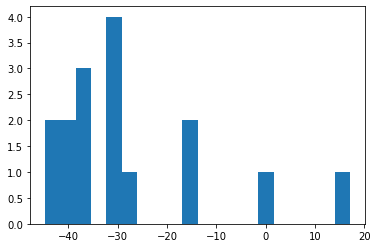

In [10]:
fig, ax = plt.subplots()
ax.hist(biases, bins=20);

(array([2., 0., 2., 0., 2., 1., 0., 3., 2., 0., 0., 0., 0., 0., 2., 0., 1.,
        0., 0., 1.]),
 array([4.48531903e+12, 4.89221974e+12, 5.29912046e+12, 5.70602117e+12,
        6.11292189e+12, 6.51982260e+12, 6.92672332e+12, 7.33362404e+12,
        7.74052475e+12, 8.14742547e+12, 8.55432618e+12, 8.96122690e+12,
        9.36812761e+12, 9.77502833e+12, 1.01819290e+13, 1.05888298e+13,
        1.09957305e+13, 1.14026312e+13, 1.18095319e+13, 1.22164326e+13,
        1.26233333e+13]),
 <BarContainer object of 20 artists>)

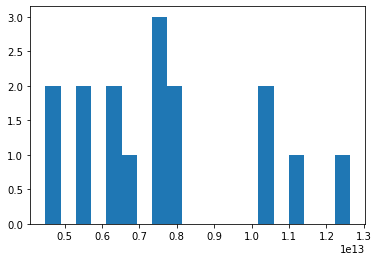

In [11]:
fig, ax = plt.subplots()
ax.hist(gains, bins=20)

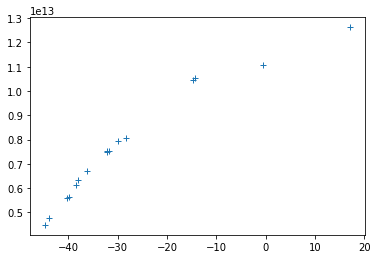

In [12]:
fig, ax = plt.subplots()
ax.plot(biases, gains, '+')

In [13]:
class ReLU:
    @staticmethod
    def inverse(a):
        return a

    @staticmethod
    def activity(x):
        return np.maximum(0, a)


class Ensemble:
    def __init__(self, n_neurons, n_dimensions, intercepts=(-0.95, 0.95), neuron_type=ReLU):
        self.neuron_type = neuron_type

        # Randomly select the intercepts and the maximum rates
        self.intercepts = np.random.uniform(*intercepts, n_neurons)
        self.max_rates = np.random.uniform(50, 100, n_neurons)

        # Randomly select the encoders
        self.encoders = np.random.normal(0, 1, (n_neurons, n_dimensions))
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, None]

        # Compute the current causing the maximum rate/the intercept
        J_0 = self.neuron_type.inverse(0)
        J_max_rates = self.neuron_type.inverse(self.max_rates)

        # Compute the gain and bias
        self.gain = (J_0 - J_max_rates) / (self.intercepts - 1.0)
        self.bias = J_max_rates - self.gain


In [14]:
ens = Ensemble(1024, 1)

(array([ 19.,  25.,  29.,  46.,  48.,  56.,  97., 162., 234., 110.]),
 array([-98.04487114, -83.54329346, -69.04171578, -54.54013811,
        -40.03856043, -25.53698275, -11.03540507,   3.46617261,
         17.96775029,  32.46932797,  46.97090565]),
 <BarContainer object of 10 artists>)

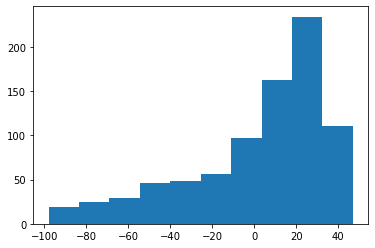

In [15]:
fig, ax = plt.subplots()
ax.hist(ens.bias[ens.bias > -100])